## Notebook for exploring the MAE of the visual features
#### Outline
-  Prepare data
    - Load model from checkpoint
    - Get image representations from iNaturalist validation dataset
- Exploring latent space of MAE model

In [1]:
import os
import time
import datetime
import json
import numpy as np
import pandas as pd
from pathlib import Path
import math
from PIL import Image
import umap
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

import torch
from torch import nn
import torchvision.transforms as transforms
# import torchvision.datasets as datasets
import torchvision.utils as vutils
from util.pos_embed import interpolate_pos_embed
from util import datasets

import models_mae
import models_vit

print(np.__version__)
print(pd.__version__)
print(torch.__version__)

path_meta = Path('meta')
path_meta.mkdir(exist_ok=True, parents=True)
path_embeddings = Path('embedding')
path_embeddings.mkdir(exist_ok=True, parents=True)

1.22.2
1.4.1
1.10.2+cu113


# Get Embedding
- from iNaturelist 2021 validation dataset
    - size: 15k
- encoder 
    - MAE encoder
    - ViT from Fine-tune of MAE encoder 

### Load encoder

In [2]:
encoder_version='eBirdFT' # 'iNatFT', 'eBirdFT' or 'eBirdPT',
norm_pixel = 'on'

global_pool = False
token = 'cls' if global_pool==False else 'gap'
data_src = 'eBirdTop100' #  'iNat', 'eBird', 'eBirdTop100'

print(f'Encoder  : {encoder_version}')
if encoder_version=='iNatFT':
    ck = Path('output_dir')/'ebird_NPon_FT_cls_vit_base_checkpoint-99.pth'   #　iNaturalist finetuned MAE
    n_classes = 1486
elif encoder_version=='eBirdPT':
    ck = Path('output_dir')/'ebird_LP_cls_2fc_vit_base_checkpoint-89.pth'   #　Ebird pretrained MAE
    n_classes =1486
elif encoder_version=='eBirdFT':
    ck = Path('output_dir')/'ebird_NPon_eBirdFT_cls_vit_base_checkpoint-149.pth'  #　eBird finetuned MAE
    n_classes = 9484

model_data_version = f'NP{norm_pixel}(Pretrain)_{encoder_version}{token}(Encoder)_{data_src}(Data)'
print(f'Embedding version : {model_data_version}')
 

Encoder  : eBirdFT
Embedding version : NPon(Pretrain)_eBirdFTcls(Encoder)_eBirdTop100(Data)


In [3]:

def load_encoder(ck, n_classes:int=1486, global_pool:bool=False, encoder_version:str='iNat_FT', **kwargs):
    # assert encoder_version == 'eBirdPT' or encoder_version =='iNatFT', f'Encoder_version must be either iNatFT or eBirdPT, got {encoder_version}'
    
    model = models_vit.__dict__['vit_base_patch16'](num_classes=n_classes, global_pool=global_pool, )
    checkpoint = torch.load(ck, map_location='cpu')
    checkpoint_model = checkpoint['model']
    state_dict = model.state_dict()

    # interpolate position embedding
    interpolate_pos_embed(model, checkpoint_model)

    # load pre-trained model
    msg = model.load_state_dict(checkpoint_model, strict=False)
    print(msg)
    return model

print(f"Load pre-trained checkpoint from: {ck}")
encoder = load_encoder(ck,n_classes=n_classes, encoder_version=encoder_version)



Load pre-trained checkpoint from: output_dir/ebird_NPon_eBirdFT_cls_vit_base_checkpoint-149.pth
<All keys matched successfully>


### Prepare dataset

In [3]:
%%time

data_path = '../../shared/iNaturalist_2021'

if data_src == 'eBird':
    val_data = 'val_ebird'
    meta_data =  '../../shared/iNaturalist_2021/meta/val_ebird.csv'
elif data_src == 'iNat':
    val_data = 'val'
    meta_data =  '../../shared/iNaturalist_2021/meta/val.csv'
elif  data_src == 'eBirdTop100':
    data_path = '../../shared/eBird/download_ebird/downloaded'
    val_data = 'jpg_top100'
    meta_data =  '../../shared/eBird/download_ebird/meta/jpg_top100_meta4.csv'
    
imgs_path = Path( data_path,val_data)
files_path_ = [f for f in imgs_path.glob('**/*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
files_path_.sort()
# exlude .ipynb files
files_path_ = [f for f in files_path_ if not f.name.startswith('.')] 
print(len(files_path_ ))

896555
CPU times: user 10.4 s, sys: 875 ms, total: 11.3 s
Wall time: 11.3 s


In [4]:
!find  {str(imgs_path)} -type f |grep -c jpg
# delete .ipynb files
!find  {str(imgs_path)} -type f |grep .ipynb  | xargs rm -v  

896555
rm: missing operand
Try 'rm --help' for more information.


##### load meta

In [4]:
%%time

df_meta =  pd.read_csv(meta_data, index_col=0)
# Establish sp_id  
if data_src == 'eBirdTop100':
    pass
elif data_src == 'iNat' or  data_src == 'eBird':
    df_meta.set_axis(df_meta.columns.str.capitalize(), axis='columns', inplace=True)
    df_meta.rename({'Scientific Name':'Sci_Name'}, axis='columns', inplace=True)
    df_meta['Sci_Name'] = df_meta.Genus + '_' + df_meta.Specific_epithet
    df_meta.sort_values(by=['File_name'], inplace=True)
    
print(f'# of Order : {df_meta.Order.nunique()}')
print(f'# of Family : {df_meta.Family.nunique()}')
print(f'# of Genus: {df_meta.Genus.nunique()}')

print(df_meta.columns)


<timed exec>:1: DtypeWarning: Columns (10,31,32,33,60) have mixed types. Specify dtype option on import or set low_memory=False.


# of Order : 41
# of Family : 249
# of Genus: 2295
Index(['ML_Catalog_Number', 'Dir_FName', 'Parent_Dir', 'Size', 'Sci_N',
       'Macaulay_public', 'Format', 'Sci_Name', 'Common_Name',
       'Background_Species', 'Recordist', 'Date', 'Year', 'Month', 'Day',
       'Time', 'Country', 'Country-State-County', 'State', 'County',
       'Locality', 'Latitude', 'Longitude', 'Elevation_(m)', 'Age/Sex',
       'Behaviors', 'Playback', 'Collected', 'Specimen_ID',
       'Home_Archive_Catalog_Number', 'Recorder', 'Microphone', 'Accessory',
       'Partner_Institution', 'eBird_Checklist_ID', 'Unconfirmed?',
       'Air_Temp(ºC)', 'Water_Temp(ºC)', 'Media_notes', 'Observation_Details',
       'Class', 'Order', 'Family', 'Parent_Species', 'eBird_Species_Code',
       'Taxon_Category', 'Taxonomic_Sort', 'Recordist_2_Display_Name',
       'Recordist_2_Profile_URL', 'Average_Community_Rating',
       'Number_of_Ratings', 'Asset_State', 'Asset_Tags',
       'Contributor_Profile_URL', 'Original_Image_

In [5]:
# 確認資料排序與meta data一致
if data_src == 'eBirdTop100':
    assert (df_meta.Dir_FName.values  == [f.parent.name + '/' + f.stem for f in files_path_]) .all()
elif data_src == 'iNat' or  data_src == 'eBird':
    assert (df_meta.File_name.values  == ['/'.join(f.parts[-3:] )for f in files_path_]).all(), f'Waining!  data : "{imgs_path}" is not aligned with metadata {meta_data}'


In [10]:

# simple augmentation
transform_toTensor = transforms.Compose([
                    transforms.Resize(256, interpolation=3),
                        transforms.CenterCrop(224),
                        transforms.ToTensor()])

dataset = datasets.ImageDatasetFromFile(files_path_, transform=transform_toTensor)
print(dataset)

# sampler = torch.utils.data.RandomSampler(dataset)
data_loader = torch.utils.data.DataLoader(
        dataset, pin_memory=True, drop_last=False,
        num_workers=8,  batch_size=100,)

/home/esslab/anaconda3/envs/mae/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


### Get Embedding

In [9]:
%%time

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # device = torch.device('cpu')
# encoder.to(device)

# start_time = time.time()
# for i, images  in enumerate(data_loader):

#     images = images.to(device)
    
#     with torch.no_grad():
#         embedding_ = encoder.forward_features(images)
#         # embedding_ = embedding_.detach().cpu().numpy()

#     if i == 0 :
#         embeddings = embedding_
#     else:
#         embeddings = torch.cat((embeddings, embedding_), axis=0)    
    
#     passing_time = str(datetime.timedelta(seconds=int(time.time() - start_time )))
#     info = f'Progress:{i+1:4d}, {100*(i+1)/len(data_loader):3.2f}%. ' 
#     info += f'| Feature_shape: {embeddings.shape}.' 
#     info += f'| Time: {passing_time}. '
#     print(info, end='\r')

#     if i==3:
#         break


CPU times: user 22min 59s, sys: 2min 15s, total: 25min 15s5, 768]).| Time: 0:38:17. 
Wall time: 38min 21s


In [6]:
%%time
file_ = f'embeddings_{model_data_version}.npz'
print(f'{file_}')
# np.savez_compressed(path_embeddings/file_, embedding=embeddings.cpu().numpy() )
# print(f'{file_} saved')
# np.save(path_embeddings.joinpath(file_) , embeddings)
embeddings = np.load(path_embeddings/file_)['embedding']
print(embeddings.shape)

# df_embedding = pd.DataFrame(embeddings)
# df_embedding

embeddings_NPon(Pretrain)_eBirdFTcls(Encoder)_eBirdTop100(Data).npz
(896555, 768)
CPU times: user 14.7 s, sys: 564 ms, total: 15.3 s
Wall time: 15.3 s


In [286]:
%%time
df_embedding = pd.DataFrame(embeddings)
df_embedding
df_dim_stat = pd.DataFrame(columns=['mean', 'std', 'min', 'max'])
df_dim_stat  = (pd.concat([df_embedding.mean(), df_embedding.std(), df_embedding.min(), df_embedding.max()], axis=1)
            .set_axis(['mean', 'std', 'min', 'max'], axis=1)
            )
df_dim_stat


,mean,std,min,max
0,-0.025510,0.131337,-0.989907,0.896051
1,0.135637,0.149344,-1.108642,1.164263
2,0.057982,0.173038,-1.057461,1.344334
3,0.013655,0.162111,-1.255681,1.011701
4,0.255946,0.191137,-1.259758,1.591336
...,...,...,...,...
763,-0.184114,0.158328,-1.561136,1.113690
764,-0.051663,0.141674,-1.698949,1.143852
765,-0.012542,0.141434,-1.007849,1.055720
766,0.076184,0.156474,-1.175945,1.195860


## Embedding Distribution

In [284]:
figsize=(6,3)`
title = f'EmbeddingDistribution\n{model_data_version}'
print(title)

EmbeddingDistribution
MAE_NPon_cls(Pretrain)_iNatFT(Encoder)_jpg_top100(Data)


In [ ]:
# df_dim_stat.plot(kind='box',figsize=figsize, title=title, ylim=(-10,10));
# (df_dim_stat[['mean',
#               'max','min'
#               ]]
#  .plot(grid=True, figsize=figsize, title=title,
#      kind='hist', bins=200, logy=True, alpha=0.5,
#        xlim=(-10,10),                     
#                                        ));

In [ ]:
# figsize=(21,3)
# ax = (df_dim_stat.reset_index().rename(columns={'index':'dim'})
#  .plot.scatter(x='dim', y='mean', label='Mean',  
#      figsize=figsize, title=title, ylim=(-2,2), xlim=(0,768), grid=True)
#  )
# figsize=(21,3)
# (df_dim_stat.reset_index().rename(columns={'index':'dim'})
#  .plot.scatter(x='dim', y='std', label='Std',
#      figsize=figsize, title=title, xlim=(0,768), grid=True, c='orange', alpha=0.5,ax=ax)
#  );



In [289]:
print(f'{encoder_version.upper()}_{token}')
df_dim_stat.query('mean > 0.5 or mean <-0.5')

INATFT_cls


,mean,std,min,max


#### plot density distribution(all dims)

In [293]:
embeddings_test = np.random.randn(30,10)
print(embeddings_test.shape)
embeddings_test.reshape(-1,1).shape

(30, 10)


(300, 1)

CPU times: user 6.49 s, sys: 148 ms, total: 6.64 s
Wall time: 6.46 s


<timed exec>:12: UserWarning:

Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



''

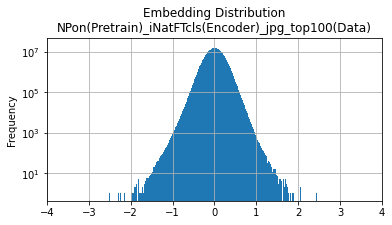

In [325]:
%%time
figsize = (6,3)
xlim=(-4,4)
ylim=(0, 5e7)

fig, ax = plt.subplots(figsize = figsize )
ax.hist(embeddings.reshape(-1,1), bins=500)
title = f'Embedding Distribution\n{model_data_version}'

ax.grid(True)
ax.set_yscale('log')
ax.set(title=title,  ylabel='Frequency',  xlim=xlim, ylim=ylim)
;

#### plot density distribution(dims with diff. color) 

CPU times: user 2min 37s, sys: 1.69 s, total: 2min 38s
Wall time: 2min 38s


<AxesSubplot:title={'center':'Embedding Distribution_EBIRD_PT_cls_ebird'}, ylabel='Frequency'>

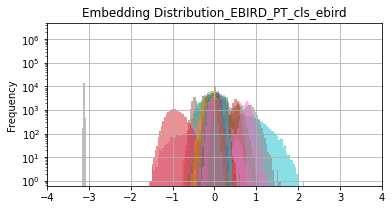

In [32]:
# %%time
# (df_embedding.plot
#    .hist(bins=500, figsize=figsize, title=title, grid=True, 
#          legend=False,  logy=True, alpha=0.5,
#          ylim=ylim,xlim=xlim,)
#     .savefig(path_embeddings/f'{title}_multi.jpg')
#       )


## Correlation btw Dimmensions

In [4]:
%%time
# matrix = df_embedding.corr()  # 13.8 s
corr_matrix = np.corrcoef(np.transpose(embeddings))
print(corr_matrix.shape)

(768, 768)
CPU times: user 5min 20s, sys: 2min 34s, total: 7min 54s
Wall time: 10.5 s


CPU times: user 2.22 s, sys: 3.67 s, total: 5.88 s
Wall time: 872 ms


''

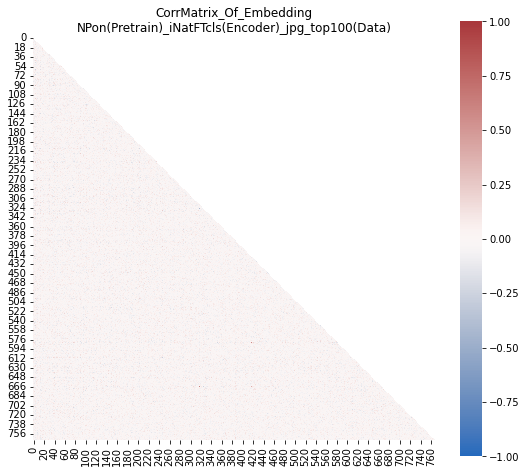

In [5]:
%%time

# 取矩陣下半三角形
mask =  np.triu(np.ones_like(corr_matrix, dtype=bool))

title = f'CorrMatrix_Of_Embedding\n{model_data_version}'
fig, ax = plt.subplots(figsize=(9, 8) )
ax.set_title(title)
sns.heatmap(corr_matrix, vmax=1, vmin=-1, center=0, square=True, 
            mask=mask,
            cmap='vlag', ax=ax)
fig.savefig(f'embedding/{title}.jpg', bbox_inches='tight',)

;

CPU times: user 68.3 ms, sys: 181 µs, total: 68.5 ms
Wall time: 66.9 ms


<timed exec>:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


''

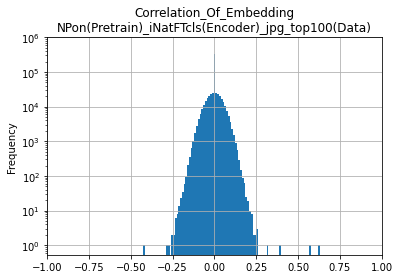

In [9]:
%%time
title = f'Correlation_Of_Embedding\n{model_data_version}'

xlim=(-1,1)
ylim=(0,1e6)
figsize = (6,4)

fig, ax = plt.subplots(figsize = figsize )
ax.hist(np.tril(corr_matrix ,k=-1).reshape(-1,1), bins=100)

ax.grid(True)
ax.set_yscale('log')
ax.set(title=title,  ylabel='Frequency',  xlim=xlim, ylim=ylim)
;
# k=-1 ，排除斜對角的數值(均為1.0) 
# fig = (pd.DataFrame(np.tril(corr_matrix ,k=-1))
#        .stack()
#        .plot(kind='hist', title=title, bins=100, grid=True, logy=True, xlim=xlim, ylim=ylim)
#       ).get_figure()
# fig.savefig(f'embedding/{title}.jpg', bbox_inches='tight',)
# ;

## Visualization of Embeddings by dimension reduction

### Labelling by Taxon

#### Data prepare

##### load embedding

In [16]:
%%time
# load embedding
encoder_version='iNatFT' # 'iNatFT' or 'eBirdPT', 'eBirdFT'
norm_pixel = 'on'

global_pool = False
token = 'cls' if global_pool==False else 'gap'
data_src = 'eBirdTop100' #  'iNat', 'eBird', 'eBirdTop100'

file_ = f'embeddings_{encoder_version}_{data_src}.npz'

embeddings = np.load(path_embeddings/file_)['embedding']
print(embeddings.shape)


(896558, 768)
CPU times: user 14.9 s, sys: 16.5 s, total: 31.4 s
Wall time: 31.5 s


##### def 'cls2label()'

In [336]:
# color_mapping =
# for x in df_meta.order.unique() 

taxon = 'order'

def cls2label(df_meta:pd.DataFrame, taxon:str='order')->list:
    class_ = np.sort(df_meta[taxon].unique())
    clsTolabel = dict((c_,l_) for c_, l_ in 
                 zip(class_, range(len(class_)))
                )
    labels = df_meta[taxon].map(clsTolabel).values
    # print(f'Number of classes : {len(class_)}')
    return labels

labels = cls2label(df_meta, taxon)
print(labels.size)
print(np.unique(labels).size)

14860
32


In [337]:
# 資料篩選 top10
topk = df_meta[taxon].nunique()

# 排除種類最多的燕雀目('Passeriformes')後、篩選前十大目
cls_list = list(df_meta.groupby([taxon]).id.count()
                .sort_values(ascending=False)[:topk].index)

 
# cls_list.remove('Passeriformes') 
# assert len(cls_list) == 10
print(len(cls_list))



32


In [276]:
print(len(df_meta))
mask = df_meta[taxon].isin(cls_list)
print(len(df_meta[mask]))

14860
14860


In [329]:
title = f'UMAP_{taxon.capitalize()}(label)'
print(title)
print(model_data_version)

UMAP_Family(label)
MAE_NPon_cls(Pretrain)_iNatFT(Encoder)_iNat(Data)


##### (合併iNat與eBird資料)

In [280]:
# encoder_version='iNatFT' # 'iNatFT' or 'eBirdPT'
# norm_pixel = 'on'

# global_pool = False
# token = 'cls' if global_pool==False else 'gap'
# data_src = 'eBird' #  'iNat', 'eBird'

v_model_data = f'MAE_NP{norm_pixel}(Pretrain)_{encoder_version}_{token}(Encoder)_{data_src}(Data)'
v_model_data

'MAE_NPon(Pretrain)_eBirdPT_cls(Encoder)_eBird(Data)'

In [217]:

# embeddings = [] 
# for src_ in ['iNat', 'eBird']:
#     file_ = f'embeddings_iNatureVal_{encoder_version}_{src_}.npz'
#     embeddings_ = np.load(path_embeddings/file_)['embedding']
#     embeddings.append(embeddings_)
# embeddings_pool  = np.concatenate(embeddings) 

# print(embeddings_pool.shape)
# half = int(embeddings_pool.shape[0]/2) # 14860


(29720, 768)


##### prepare labels

In [220]:
# %%time
# label_cls = 'order' # 'datasrc'

# data_src= 'pool' 
# v_model_data = f'MAE_NP{norm_pixel}_{token}(Pretrain)_{encoder_version}(Encoder)_{data_src}(Data)'
# print(f'Embedding version : {v_model_data}')

# if not label_cls.startswith('data'): 
#     labels_pool = list(labels) + list(labels)
   
#     title = f'UMAP_{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{label_cls.capitalize()}(label)'
# else:
#     labels_pool = [0]*half + [1]*half
#     assert len(labels_pool) == half*2
#     title = f'UMAP projection_{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_DataSrc(label)'


# print(title)

# print(f'Number of labels : {len(labels_pool)}')
# print(f'Shape of embeddingss : {embedding_umap_pool.shape}\n')

Embedding version : MAE_NPon_cls(Pretrain)_iNatFT(Encoder)_pool(Data)
UMAP_200(n_nei)_Euc(metric)_Order(label)
Number of labels : 29720
Shape of embeddingss : (29720, 2)

CPU times: user 1.51 ms, sys: 48 µs, total: 1.56 ms
Wall time: 1.4 ms


In [221]:
# # Filter Top10 'order'

# labels_pool = list(labels[mask]) + list(labels[mask])
# print(len(labels_pool))
# title = f'UMAP_{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{label_cls.capitalize()}Top10(label)'
# print(f'Embedding version : {v_model_data}')

# # labels_pool = [0]*half + [1]*half
# # assert len(labels_pool) == half*2
# # title = f'UMAP projection_{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_DataSrc(label)'


# # np.concatenate([embedding_umap[:half][mask],
# #                 embedding_umap[half:][mask]
# #                ]).shape


# print(embedding_umap_pool[list(mask) + list(mask)].shape)

12540
Embedding version : MAE_NPon_cls(Pretrain)_iNatFT(Encoder)_pool(Data)
(12540, 2)


#### Setting colors for plot

In [281]:
# Customized palette

label_cls = 'order'

if label_cls.startswith('data'):
    palette_cus = ['#00ff00', '#0000ff']

elif label_cls == 'order': # num_order = 32
    palette_cus = ['#696969', '#556b2f', '#228b22', '#7f0000', '#483d8b', '#b8860b', '#008b8b', '#9acd32', '#00008b', '#7f007f', '#8fbc8f', '#b03060', '#ff4500', 
                   '#ff8c00', '#ffd700', '#00ff00', '#9400d3', '#00ff7f', '#e9967a', '#dc143c', '#00ffff', '#00bfff', '#0000ff', '#d8bfd8', '#ff00ff', '#1e90ff', 
                   '#f0e68c', '#90ee90', '#ff1493', '#7b68ee', '#ee82ee', '#ffffe0']
 
    

print(len(palette_cus))

32


#### def `plot_2DScatter_taxon()`

In [48]:

def plot_2DScatter_taxon(embedding, labels:np.ndarray=None, 
                   color:str='lightblue', alpha=0.3, 
                   figsize:tuple=(12,8), size=10.0 ,
                   save:bool=True, **kwds)->None:
    fig, ax = plt.subplots(figsize=figsize)

    if type(labels) == np.ndarray or type(labels) == list:
        color = [sns.color_palette(palette_cus)[l] for l in labels]
    else:
        color=color

    ax.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=color, s=size, lw=size*0.01, alpha=alpha, edgecolors='black',   
        ).get_figure()
    plt.gca().set_aspect('equal', 'datalim')

    plt.title(title, y=1.05, fontsize=14)
    plt.suptitle(f'{v_model_data}', y=0.91, fontsize=12, fontweight='light')
    # plt.figure(figsize=figsize)
    if save:
        c_ = 'mono' if type(color) == str else 'color'
        fig.savefig(f'embedding/{n_components}D_{title}_{c_}_{v_model_data}.jpg', bbox_inches='tight',)
    ;

In [ ]:
# %%time
# plot_2DScatter(embedding_umap, labels, figsize=(12,8), size=5.0 ,alpha=0.1,
#                save=True, title=title, v_model_data=v_model_data,)

#### Dimension reduction by UMAP

In [338]:
n_neighbors_ = math.ceil(df_meta.groupby([taxon]).id.count().mean())
n_neighbors_

465

In [ ]:

seed=0
# n_neighbors_ = math.ceil(df_meta.groupby([taxon]).id.count().mean())
# n_neighbors = n_neighbors_ if n_neighbors_ >=15 else 15
n_neighbors = 15
n_components = 2
metric='euclidean' # 'cosine', 'euclidean' 
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, metric=metric,  random_state=seed, verbose=True)
print(n_neighbors)

In [ ]:
%%time
# print(embeddings_pool.shape)
# embedding_umap_pool = reducer.fit_transform(embeddings_pool)
# print(embedding_umap_pool.shape)

print(embeddings.shape)
embedding_umap  = reducer.fit_transform(embeddings)
print(embedding_umap.shape)

In [ ]:
file_ = f'embeddings_umap{n_components}D_{n_neighbors}(n_nei)_{encoder_version}_{data_src}.npz'

np.savez_compressed(path_embeddings/file_, embedding_umap=embedding_umap )
print(f'{file_} saved')

embedding_umap = np.load(path_embeddings/file_)['embedding_umap']
print(embedding_umap.shape)


In [ ]:
# %%time
# plot_Scatter2D(embedding[list(mask) + list(mask)], labels, figsize=(16,12), size=10.0 ,alpha=0.3,
#                save=True, title=title, v_model_data=v_model_data,)

#### def `plot_3DScatter_taxon()`

In [246]:

def plot_3DScatter_taxon(embedding, labels, taxon
                       color_discrete_map:dict=None, 
                       opacity=0.5, width=900, marker_size:int=2, **kwds ):
    fig = px.scatter_3d(
        embedding, x=0, y=1, z=2,
        labels=dict(color=taxon),
        color=labels, 
        color_discrete_map=color_discrete_map,
        # color_continuous_scale=px.colors.diverging.Spectral,
        title=title,
        opacity=opacity, )

    fig.update_layout(
        width=width, height=width*2/3,
        # tight layout
        margin=dict(r=0, l=0, b=0, t=30),
        template='plotly_dark',
        legend=dict(
            x=0.8, y=1,
            itemsizing = 'constant',
            # traceorder = 'reversed', # "reversed", "grouped", "reversed+grouped", "normal"
            bordercolor="Black", borderwidth=0.1)
    )
    fig.update_traces(marker_size=2, )

    fig.show()
    fig.write_html(save_file, auto_open=True)



In [54]:
n_components=3 
n_neighbors = 500

file_ = f'embeddings_umap{n_components}D_{n_neighbors}(n_nei)_{encoder_version}_{data_src}.npz'
print(f'{file_} loaded' )

embedding_umap = np.load(path_embeddings/file_)['embedding_umap']
print(embedding_umap.shape)

embeddings_umap3D_500(n_nei)_iNatFT_eBirdTop100.npz loaded
(896558, 3)


In [59]:
v_model_data = f'NP{norm_pixel}(Pretrain)_{encoder_version}{token}(Encoder)_{data_src}(Data)'
v_model_data

'NPon(Pretrain)_iNatFTcls(Encoder)_eBirdTop100(Data)'

In [250]:
save_path = Path(f'embedding/umap_Taxon/')
title = f'UMAP_Latitude'
subtitle = f'{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{v_model_data}'
save_file = f'{save_path}/{n_components}D_{taxon}_{title}_{subtitle}.html'

color_discrete_map = dict(zip(np.sort(df_meta['lat_group'].unique()),
                                       px.colors.diverging.Spectral[1::2]))

plot_3DScatter_taxon(embedding_umap3d[idx], labels=df_meta['lat_group'][idx], taxon,
                   color_discrete_map=color_discrete_map,
                   marker_size=3,
                   save_file=save_file)

In [69]:
%%time
path_meta_file = '../../shared/eBird/download_ebird/meta/jpg_top100_meta3.csv'
df_meta =  pd.read_csv(path_meta_file, index_col=0)
print(df_meta.columns)

In [69]:
col_sel = ['ML Catalog Number']
col_taxon = ['Order', 'Family', 'Parent Species', 'eBird Species Code',
       'Taxon Category', 'Taxonomic Sort', 'Sci_N', 'Scientific Name']
col_time = ['Date', 'Year', 'Month', 'Day', 'Time']
col_geo = [ 'County', 'Locality', 'Latitude', 'Longitude', 'Elevation (m)']
col_ratine = ['Average Community Rating','Number of Ratings']
df_meta[col_sel + col_taxon]

<timed exec>:2: DtypeWarning:

Columns (31,32,33,60) have mixed types. Specify dtype option on import or set low_memory=False.



Index(['ML Catalog Number', 'Dir_FName', 'Parent_Dir', 'Size', 'Sci_N',
       'Macaulay_public', 'Format', 'Scientific Name', 'Common Name',
       'Background Species', 'Recordist', 'Date', 'Year', 'Month', 'Day',
       'Time', 'Country', 'Country-State-County', 'State', 'County',
       'Locality', 'Latitude', 'Longitude', 'Elevation (m)', 'Age/Sex',
       'Behaviors', 'Playback', 'Collected', 'Specimen ID',
       'Home Archive Catalog Number', 'Recorder', 'Microphone', 'Accessory',
       'Partner Institution', 'eBird Checklist ID', 'Unconfirmed?',
       'Air Temp(ºC)', 'Water Temp(ºC)', 'Media notes', 'Observation Details',
       'Class', 'Order', 'Family', 'Parent Species', 'eBird Species Code',
       'Taxon Category', 'Taxonomic Sort', 'Recordist 2 Display Name',
       'Recordist 2 Profile URL', 'Average Community Rating',
       'Number of Ratings', 'Asset State', 'Asset Tags',
       'Contributor Profile URL', 'Original Image Height',
       'Original Image Width', 'Spe

,ML Catalog Number,Order,Family,Parent Species,eBird Species Code,Taxon Category,Taxonomic Sort,Sci_N,Scientific Name
0,114289801,NaN,Acanthisittidae,Acanthisitta chloris,riflem1,Species,12455.0,Acanthisitta_chloris_0,Acanthisitta chloris
1,114289821,NaN,Fringillidae,Acanthisitta chloris,riflem1,Species,12455.0,Acanthisitta_chloris_0,Acanthisitta chloris
2,114404941,NaN,Acanthisittidae,Acanthisitta chloris,riflem1,Species,12455.0,Acanthisitta_chloris_0,Acanthisitta chloris
3,114404951,NaN,Fringillidae,Acanthisitta chloris,riflem1,Species,12455.0,Acanthisitta_chloris_0,Acanthisitta chloris
4,115495451,NaN,Acanthisittidae,Acanthisitta chloris,riflem1,Species,12550.0,Acanthisitta_chloris_0,Acanthisitta chloris
...,...,...,...,...,...,...,...,...,...
896550,59630711,NaN,Zosteropidae,Zosterornis whiteheadi,chfbab1,Species,25187.0,Zosterornis_whiteheadi_0,Zosterornis whiteheadi
896551,59630721,NaN,Zosteropidae,Zosterornis whiteheadi,chfbab1,Species,25187.0,Zosterornis_whiteheadi_0,Zosterornis whiteheadi
896552,63554951,NaN,Zosteropidae,Zosterornis whiteheadi,chfbab1,Species,25187.0,Zosterornis_whiteheadi_0,Zosterornis whiteheadi
896553,79738531,NaN,Zosteropidae,Zosterornis whiteheadi,chfbab1,Species,24517.0,Zosterornis_whiteheadi_0,Zosterornis whiteheadi


In [70]:
%%time
save_path = Path(f'embedding/umap_Taxon/')
save_path.mkdir(exist_ok=True, parents=True) 

taxon='Order'
title = f'UMAP_Latitude'
subtitle = f'{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{v_model_data}'
save_file = f'{save_path}/{n_components}D_{taxon}_{title}_{subtitle}.html'
width=900

fig = px.scatter_3d(
    embedding_umap, x=0, y=1, z=2,
    # labels=dict(color=taxon),
    color=df_meta.Family, 
    # color_discrete_map=color_discrete_map,
    # # color_continuous_scale=px.colors.diverging.Spectral,
    title=title,
    opacity=0.5, )

fig.update_layout(
    width=width, height=width*2/3,
    # tight layout
    margin=dict(r=0, l=0, b=0, t=30),
    template='plotly_dark',
    legend=dict(
        x=0.8, y=1,
        itemsizing = 'constant',
        # traceorder = 'reversed', # "reversed", "grouped", "reversed+grouped", "normal"
        bordercolor="Black", borderwidth=0.1)
)
fig.update_traces(marker_size=2, )

fig.show()
fig.write_html(save_file, auto_open=True)


ValueError: All arguments should have the same length. The length of argument `color` is 896555, whereas the length of  previously-processed arguments ['0', '1', '2'] is 896558

#### 以單色凸顯個別類群
#### def `plot_2D_byCls()`

In [260]:
# plot by class
save_path = Path(f'embedding/umap_color1_{taxon}_{data_src}(Data)')
save_path.mkdir(exist_ok=True)

def plot_2D_byCls(embedding:np.array 
                  cls_:str, taxon:str='order', labels=labels, df=df_meta,
                  figsize:tuple=(16,12) ,size:float=15, alpha=0.7,
                  save:bool=True, save_path=save_path,  
                  **kwds
                 )->None:
    fig, ax = plt.subplots(figsize=figsize)

    # 取得單一類別的index位置 
    idx_cls_ = df[df[taxon] == cls_].index.values

    # 建立所有類別的scatter底圖
    ax.scatter(embedding[:, 0], embedding[:, 1], 
                c='lightgrey', lw=size*0.005, s=size*0.7, edgecolors='black', alpha=alpha*0.7)

    # 建立單一欲顯色的類別scatter圖
    scatter = ax.scatter(embedding[idx_cls_, 0], embedding[idx_cls_, 1],
                         c=labels[idx_cls_],
                         lw=size*0.01, s=size, edgecolors='black', cmap='Spectral', alpha=alpha)

    # 取出legen元素，圖標 handles與 標籤labels
    handles, labls = scatter.legend_elements()  # labels
    # family_list = [Fam_dic[int(labels[l].split("{")[1].split("}")[0])] for l in range(len(labels))]  # 將編碼過的數字標籤反轉換為文字
    ax.legend(
    #     *scatter.legend_elements(),
        handles=handles, 
        labels= [cls_] ,
        title=taxon, ncol=2, markerscale=1, fontsize=12)

    plt.title(title, y=1.03, fontsize=16)
    subtitle = f'{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{v_model_data}'
    plt.suptitle(subtitle, y=0.9, fontsize=12, fontweight='light')
    plt.gca().set_aspect('equal', 'datalim')
    if save==True:
        fig.savefig(Path(save_path)/f'{n_components}D_Color1_{title}_{subtitle}.jpg', bbox_inches='tight',)
    ;



In [345]:
# title = f'UMAP(metric)_{order_.capitalize()}(label)'
# print(title)

v_model_data = f'MAE_NP{norm_pixel}(Pretrain)_{encoder_version}_{token}(Encoder)_{data_src}(Data)'
print(v_model_data)

print(embedding_umap.shape)
# df_meta_pool = pd.concat([df_meta, df_meta])
# print(len(df_meta_pool))


MAE_NPon(Pretrain)_iNatFT_cls(Encoder)_eBird(Data)
(14860, 2)


#### labelling by taxon

In [342]:
 
cls_list = list(df_meta.groupby([taxon]).id.count()
                .sort_values()[-topk:].index)
print(len(cls_list))

save_path = Path(f'embedding/umap_color1/{encoder_version}_{data_src}_{taxon}')
save_path.mkdir(exist_ok=True)

32


In [343]:
%%time

for cls_ in cls_list:
    title = f'UMAP_{cls_.capitalize()}(label)'
    plot_2D_byCls(embedding_umap , df_meta , cls_, taxon=taxon,
              figsize=(16,12), size =15, alpha=0.7,
              save=True, save_path=save_path, title=title, v_model_data=v_model_data)
    plt.close();

CPU times: user 7.43 s, sys: 5.43 s, total: 12.9 s
Wall time: 5.54 s


#### (UMAP2PCA)

In [155]:
%%time
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=3, metric=metric,  random_state=seed, verbose=True)

embedding_umap = reducer.fit_transform(embeddings)
print(embedding_umap.shape)

pca = PCA(n_components=n_components)
embedding_PCA = pca.fit_transform(embedding_umap)
print(embedding_PCA.shape)

UMAP(n_components=3, n_neighbors=22, random_state=0, verbose=True)
Fri Jun 10 16:17:03 2022 Construct fuzzy simplicial set
Fri Jun 10 16:17:03 2022 Finding Nearest Neighbors
Fri Jun 10 16:17:03 2022 Building RP forest with 11 trees
Fri Jun 10 16:17:03 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Fri Jun 10 16:17:05 2022 Finished Nearest Neighbor Search
Fri Jun 10 16:17:06 2022 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:08]


Fri Jun 10 16:17:14 2022 Finished embedding
(14860, 3)
CPU times: user 1min 26s, sys: 22.4 s, total: 1min 49s
Wall time: 11.1 s


In [154]:
%%time
save_path = Path(f'embedding/umap_color1/{encoder_version}_{taxon}_UMAP2PCA')
save_path.mkdir(exist_ok=True, parents=True)

for cls_ in cls_list:
    title = f'UMAP2PCA_{taxon.capitalize()} {cls_.capitalize()}(label)'
    plot_2D_byCls(embedding_umap, df_meta, cls_, taxon=taxon, labels=labels,
              figsize=(16,12), size=15, alpha=0.7,
              save=True, save_path=save_path, title=title, v_model_data=v_model_data)
    plt.close();

CPU times: user 13.7 s, sys: 13.8 s, total: 27.5 s
Wall time: 8.78 s


#### Labelling by Family on Genus Median

##### Genus Median

In [175]:
emb_genus_median = (pd.concat([df_meta[['family','genus']], 
                              pd.DataFrame(embeddings)], axis=1)
                   .groupby(['family', 'genus']).median()).values
print(emb_genus_median.shape)

(648, 768)


In [179]:
df_fam_genus = df_meta.groupby(['family', 'genus']).count().reset_index()[['family', 'genus']]
df_fam_genus

,family,genus
0,Acanthisittidae,Acanthisitta
1,Acanthizidae,Acanthiza
2,Acanthizidae,Gerygone
3,Acanthizidae,Sericornis
4,Accipitridae,Accipiter
...,...,...
643,Upupidae,Upupa
644,Viduidae,Vidua
645,Vireonidae,Cyclarhis
646,Vireonidae,Vireo


In [205]:
taxon = 'family'
labels = cls2label(df_fam_genus, taxon)
print(labels.size)
print(np.unique(labels).size)

648
147


##### UMAP

In [195]:
seed=0
n_neighbors_ = math.ceil(df_fam_genus.groupby(['family']).count().mean()) 
n_neighbors = n_neighbors_ if n_neighbors_ >=15 else 15
# n_neighbors = 100
print(f'n_neighbors : {n_neighbors}')
n_components=2
metric='euclidean' # 'cosine', 'euclidean' 
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, metric=metric,  random_state=seed, verbose=True)

n_neighbors : 15


In [197]:
%%time
print(emb_genus_median.shape)
embedding_umap = reducer.fit_transform(emb_genus_median)
print(embedding_umap.shape)

(648, 768)
UMAP(random_state=0, verbose=True)
Fri Jun 10 16:46:17 2022 Construct fuzzy simplicial set
Fri Jun 10 16:46:17 2022 Finding Nearest Neighbors
Fri Jun 10 16:46:17 2022 Finished Nearest Neighbor Search
Fri Jun 10 16:46:17 2022 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [00:01]

Fri Jun 10 16:46:18 2022 Finished embedding
(648, 2)
CPU times: user 5.23 s, sys: 5.48 s, total: 10.7 s
Wall time: 1.54 s


 ##### plot by Family on Genus Median

In [206]:
# 資料篩選 topk
topk = 30 
cls_list = list(df_meta.groupby([taxon]).id.count()
                .sort_values()[-topk :].index)

In [226]:
%%time
save_path = Path(f'embedding/umap_color1/{encoder_version}_{taxon}')
save_path.mkdir(exist_ok=True, parents=True)

for cls_ in cls_list:
    title = f'UMAP_{taxon.capitalize()} {cls_.capitalize()}(label)'
    plot_2D_byCls(embedding_umap, df_meta, cls_, taxon=taxon, 
                  labels=labels, df=df_meta,
                  figsize=(16,12), size=15, alpha=0.8,
                  save=True, save_path=save_path, title=title, v_model_data=v_model_data)
    plt.close();

CPU times: user 11.9 s, sys: 8.52 s, total: 20.4 s
Wall time: 8.99 s


### Taxon in different Latitude Zone

#### data prepare

##### load embedding

In [33]:
# load embedding
encoder_version='iNatFT' # 'iNatFT' or 'eBirdPT'
norm_pixel = 'on'

global_pool = False
token = 'cls' if global_pool==False else 'gap'
data_src = 'iNat' #  'iNat', 'eBird'

v_model_data = f'MAE_NP{norm_pixel}(Pretrain)_{encoder_version}_{token}(Encoder)_{data_src}(Data)'
print(v_model_data)

file_ = f'embeddings_iNatureVal_{encoder_version}_{data_src}.npz'
embeddings = np.load(path_embeddings/file_)['embedding']
print(embeddings.shape)


MAE_NPon(Pretrain)_iNatFT_cls(Encoder)_iNat(Data)
(14860, 768)


##### load meta

In [34]:
meta_data =  '../../shared/iNaturalist_2021/meta/val.csv'
df_meta =  pd.read_csv(meta_data, index_col=0)
# Establish sp_id 
df_meta['Sci_Name'] = df_meta.genus + '_' + df_meta.specific_epithet
sp_list = np.sort(df_meta.Sci_Name.unique())
mapping_dict = dict(zip(sp_list, range(sp_list.size)))
df_meta['sp_id'] = df_meta.Sci_Name.map(mapping_dict)

df_meta['Year'] = df_meta.date.apply(lambda x :x.split('-')[0]).astype(np.uint16)
df_meta['Month'] = df_meta.date.apply(lambda x :x.split('-')[1]).astype(np.uint8)

col_ts = ['Year','Month', 'latitude', 'longitude','location_uncertainty']
col_taxon = ['order', 'family', 'genus', 'Sci_Name']
col_sel = col_taxon + col_ts

df_meta[col_sel]
print(df_meta.columns)
print(f'# of Order : {df_meta.order.nunique()}')
print(f'# of Family : {df_meta.family.nunique()}')
print(f'# of Genus: {df_meta.genus.nunique()}')

Index(['id', 'category_id', 'width', 'height', 'file_name', 'license',
       'rights_holder', 'date', 'latitude', 'longitude',
       'location_uncertainty', 'name', 'common_name', 'supercategory',
       'kingdom', 'phylum', 'class', 'order', 'family', 'genus',
       'specific_epithet', 'image_dir_name', 'Sci_Name', 'sp_id', 'Year',
       'Month'],
      dtype='object')
# of Order : 32
# of Family : 147
# of Genus: 648


In [1023]:
df_meta[col_sel].describe()

,Year,Month,latitude,longitude,location_uncertainty
count,14860.000000,14860.000000,14831.000000,14831.000000,1.268200e+04
mean,2016.442665,6.132503,15.985711,-20.095249,1.152137e+04
std,3.373034,3.220147,30.127113,91.577974,1.381098e+05
min,1975.000000,1.000000,-64.630980,-177.362550,0.000000e+00
25%,2015.000000,4.000000,-6.862830,-95.910560,3.100000e+01
50%,2018.000000,6.000000,23.740890,-65.592460,2.010000e+02
75%,2019.000000,9.000000,39.873085,35.734670,2.273750e+03
max,2019.000000,12.000000,79.936440,178.449460,1.127110e+07


In [35]:
idx = df_meta[df_meta.latitude.notnull()].index.values
df_meta = df_meta.dropna(subset=['latitude']).copy()

##### cut by latitude

In [36]:
bins = np.arange(0, 90.1, 15)
print('bins : ', bins) 
df_meta['lat_group'] = pd.cut(df_meta.latitude.abs(), bins=bins,)  # labels=list(range(len(bins[1:])))
                              
labels_ = df_meta['lat_group'].sort_values().unique()
print('Number of interval : ', len(labels_)) 
                              
intval2Int = dict(zip(labels_ , range(len(labels_)))) 
int2Intval = dict(zip(range(len(labels_)), labels_))                        

print('\n', df_meta.groupby(['lat_group']).id.count(), '\n')
labels = df_meta['lat_group'].map(intval2Int)
print(f'After transorm to int : \n{labels.unique()}')


bins :  [ 0. 15. 30. 45. 60. 75. 90.]
Number of interval :  6

 lat_group
(0.0, 15.0]     2181
(15.0, 30.0]    4402
(30.0, 45.0]    5846
(45.0, 60.0]    2200
(60.0, 75.0]     196
(75.0, 90.0]       6
Name: id, dtype: int64 

After transorm to int : 
[1, 2, 3, 0, 4, 5]
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]


#### Dimension reduction by UMAP

In [37]:
n_neighbors_ = math.ceil(df_meta.groupby(['lat_group']).id.count().mean())
if n_neighbors_ > 200:
    n_neighbors = 200 
elif n_neighbors_ < 15:
    n_neighbors = 15
else:
    n_neighbors = n_neighbors_
print(n_neighbors_, n_neighbors) 

2472 200


In [38]:
seed=0
n_components=3
metric='euclidean' # 'cosine', 'euclidean' 
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, metric=metric,  random_state=seed, verbose=True)
print(n_neighbors)

200


In [39]:
%%time
# print(embeddings_pool.shape)
# embedding_umap_pool = reducer.fit_transform(embeddings_pool)
# print(embedding_umap_pool.shape)

print(embeddings.shape)
embedding_umap  = reducer.fit_transform(embeddings)
print(embedding_umap.shape)

(14860, 768)
UMAP(n_neighbors=200, random_state=0, verbose=True)
Thu Jun 16 16:32:41 2022 Construct fuzzy simplicial set
Thu Jun 16 16:32:41 2022 Finding Nearest Neighbors
Thu Jun 16 16:32:41 2022 Building RP forest with 11 trees
Thu Jun 16 16:32:42 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	Stopping threshold met -- exiting after 6 iterations
Thu Jun 16 16:33:25 2022 Finished Nearest Neighbor Search
Thu Jun 16 16:33:29 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Jun 16 16:33:47 2022 Finished embedding
(14860, 2)
CPU times: user 18min 17s, sys: 12min 19s, total: 30min 37s
Wall time: 1min 6s


#### def `plot_2DScatter_Lat()`

In [40]:
def plot_2DScatter_Lat(embedding, labels:np.ndarray=None,  
                   alpha=0.3, size=10.0 , figsize:tuple=(12,8), 
                   show_legend:bool=False,
                   save:bool=True, **kwds)->None:
    
    fig, ax = plt.subplots(figsize=figsize)
    color = np.array(labels)
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1],
                        s=size, lw=size*0.02, alpha=alpha, edgecolors='black', 
                         c=color, cmap='Spectral') 
    # Legend
    # legend = ax.legend(*scatter.legend_elements(), title="Laitude")
    # ax.add_artist(legend)
    # 取出legen元素，圖標 handles與 標籤labels
    if show_legend:
        handles, labels_ = scatter.legend_elements()  # labels
        def get_int(x): 
            return int(x.split("{")[1].split("}")[0])
        ax.legend(
            handles=handles, 
            labels = [int2Intval[get_int(labels_[l])] for l in range(len(labels_))] ,
            # labels = [int2Intval[int(labels_[l].split("{")[1].split("}")[0])] for l in range(len(labels_))] ,
            title=title_legent, markerscale=1)
    
    plt.gca().set_aspect('equal', 'datalim')

    plt.title(title, y=1.05, fontsize=14)
    subtitle = f'{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{v_model_data}'
    plt.suptitle(subtitle, y=0.91, fontsize=12, fontweight='light')
    # plt.figure(figsize=figsize)
    if save:
        fig.savefig(f'{Path(save_path)}/{n_components}D_Laitude_{title}_{subtitle}.jpg', bbox_inches='tight',)
    ;
    

- all

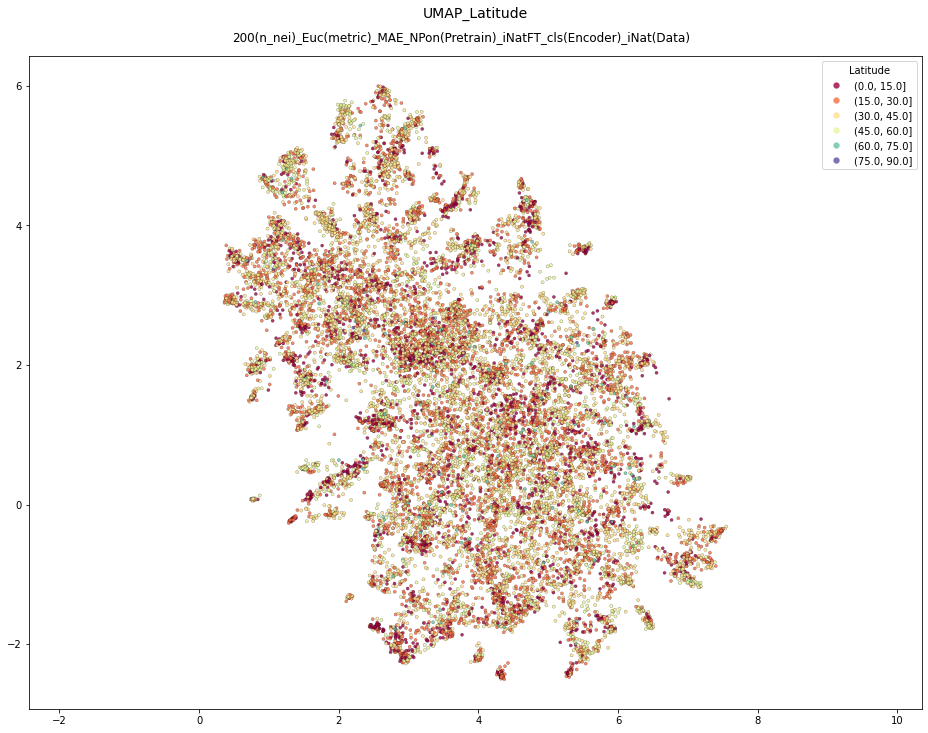

In [999]:
save_path = Path(f'embedding/umap_Latitude/{encoder_version}_{data_src}_{len(labels.unique())}(Lat)')
save_path.mkdir(exist_ok=True, parents=True)

title = f'UMAP_Latitude'
title_legent='Latitude'

plot_2DScatter_Lat(embedding_umap[idx], labels,
                   figsize=(16,12), size=10, alpha=0.8,
                   show_legend=True, title_legent=title_legent,
                   save_path=save_path, title=title, v_model_data=v_model_data)

#### def `plot_3DScatter_Lat()`

##### 3D umap

In [ ]:
%%time

seed=0
n_components=3
metric='euclidean' # 'cosine', 'euclidean' 
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, metric=metric,  random_state=seed, verbose=True)
print(n_neighbors)

print(embeddings.shape)
embedding_umap3d  = reducer.fit_transform(embeddings)
print(embedding_umap3d.shape)

In [246]:
import plotly.express as px
import plotly.graph_objects as go


def plot_3DScatter_Lat(embedding, labels, 
                       color_discrete_map:dict=None,
                      width=900, marker_size:int=2, **kwds ):
    fig = px.scatter_3d(
        embedding, x=0, y=1, z=2,
        labels=dict(color='Latitude_Zone'),
        color=labels, 
        color_discrete_map=color_discrete_map,
        # color_continuous_scale=px.colors.diverging.Spectral,
        title=title,
        opacity=0.5, 
    )

    fig.update_layout(
        width=width, height=width*2/3,
        # tight layout
        margin=dict(r=0, l=0, b=0, t=30),
        template='plotly_dark',
        legend=dict(
            x=0.8, y=1,
            itemsizing = 'constant',
            # traceorder = 'reversed', # "reversed", "grouped", "reversed+grouped", "normal"
            bordercolor="Black", borderwidth=0.1)
    )
    fig.update_traces(marker_size=2, )

    fig.show()
    fig.write_html(save_file, auto_open=True)



In [250]:
save_path = Path(f'embedding/umap_Latitude/')
title = f'UMAP_Latitude'
subtitle = f'{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{v_model_data}'
save_file = f'{Path(save_path)}/{n_components}D_Laitude_{title}_{subtitle}.html'

color_discrete_map = dict(zip(np.sort(df_meta['lat_group'].unique()),
                                       px.colors.diverging.Spectral[1::2]))

plot_3DScatter_Lat(embedding_umap3d[idx], labels=df_meta['lat_group'][idx],
                   color_discrete_map=color_discrete_map,
                   marker_size=3,
                   save_file=save_file
                  )

#### Photo taken in different Latitude Zone

- 中高緯度、冬季的照片
    - latitude > 45 (about Seattle)
    - month : 12, 1

In [198]:
zone = 'High_Winter'
lat = 45
con1 =  (df_meta['latitude'] > lat ) & (df_meta['Month'].isin([12, 1]))
con2 = (df_meta['latitude'] < -lat) & (df_meta['Month'].isin([6, 7]))
idx_zone = df_meta[con1 | con2].index.values
print(len(idx_zone))
# df_meta.loc[idx_high]

174


In [1010]:
zone = 'Tropical'
lat = 15
mask =  (df_meta['latitude'] < lat)  & (df_meta['latitude'] > -lat)
idx_zone = df_meta[mask].index.values
print(len(idx_zone)


2181


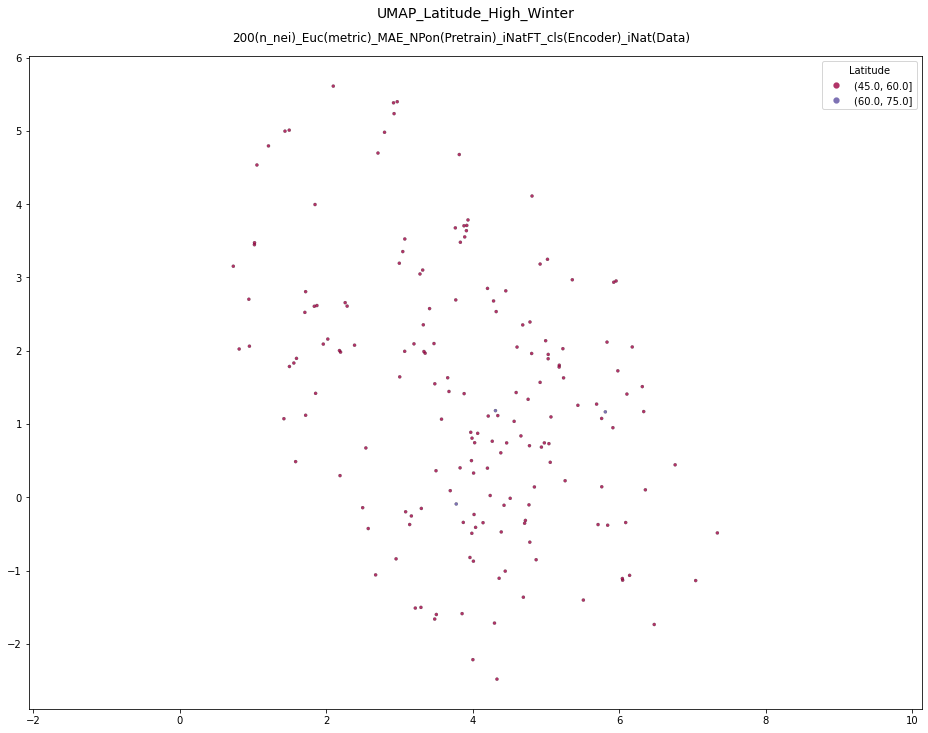

In [1018]:
save_path = Path(f'embedding/umap_Latitude/{encoder_version}_{data_src}_{len(labels.unique())}(Lat)')
save_path.mkdir(exist_ok=True, parents=True)


title = f'UMAP_Latitude_{zone}'
title_legent='Latitude'

plot_2DScatter_Lat(embedding_umap[idx_zone], labels[idx_zone],
              figsize=(16,12), size=10, alpha=0.8,
              show_legend=True, title_legent=title_legent,
            save_path=save_path, title=title, v_model_data=v_model_data)


In [249]:
save_path = Path(f'embedding/umap_Latitude/')
title = f'UMAP_Latitude_{zone}'
subtitle = f'{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{v_model_data}'
save_file = f'{Path(save_path)}/{n_components}D_Laitude_{title}_{subtitle}.html'

color_discrete_map = dict(zip(np.sort(df_meta['lat_group'].unique()),
                                       px.colors.diverging.Spectral[1::2]))

plot_3DScatter_Lat(embedding_umap3d[idx_zone], labels=df_meta['lat_group'][idx_zone],
                   color_discrete_map=color_discrete_map,
                   marker_size=3,
                   save_file=save_file
                  )

#### Check the latitude distribution of each taxon
- Identify taxon with a wide distribution across latitudes

In [778]:
print(df_meta.columns )
# idx_order = df_meta.columns.get_loc("order")


Index(['id', 'category_id', 'width', 'height', 'file_name', 'license',
       'rights_holder', 'date', 'latitude', 'longitude',
       'location_uncertainty', 'name', 'common_name', 'supercategory',
       'kingdom', 'phylum', 'class', 'order', 'family', 'genus',
       'specific_epithet', 'image_dir_name', 'Sci_Name', 'sp_id', 'lat_group'],
      dtype='object')


In [847]:
taxon = 'genus'
# taxon = 'genus'
col_gp = ['order'] 
if taxon == 'family':
    col_gp += ['family']
elif taxon == 'genus':
    col_gp += ['family','genus']
elif taxon == 'Sci_Name':
    col_gp += ['family','genus', 'Sci_Name']
col_gp

['order', 'family', 'genus']

In [848]:
lat_dist = (df_meta.groupby(col_gp)
            .latitude.agg(['min', 'max', np.median, 'count'])
            .reset_index() )
lat_dist['range'] = lat_dist.eval('max-min')
print(len(lat_dist))
lat_dist = lat_dist.query('count>=50')
print(len(lat_dist))

lat_dist.sort_values(by=['range']).tail(15)

648
63


,order,family,genus,min,max,median,count,range
41,Anseriformes,Anatidae,Aythya,-45.97001,60.80921,38.971185,100,106.77922
8,Accipitriformes,Accipitridae,Circus,-45.84697,61.73735,45.953680,60,107.58432
146,Charadriiformes,Scolopacidae,Calidris,-38.85283,71.37447,40.437635,190,110.22730
127,Charadriiformes,Laridae,Chroicocephalus,-50.33997,60.97524,-25.277805,90,111.31521
294,Passeriformes,Emberizidae,Emberiza,-43.04371,68.33174,43.442370,90,111.37545
121,Charadriiformes,Haematopodidae,Haematopus,-46.94876,64.87177,-33.760900,80,111.82053
379,Passeriformes,Motacillidae,Anthus,-44.20813,68.36544,36.413495,110,112.57357
40,Anseriformes,Anatidae,Anser,-34.55694,78.20860,42.156545,80,112.76554
230,Gruiformes,Rallidae,Fulica,-53.11604,60.71711,-11.182350,50,113.83315
590,Podicipediformes,Podicipedidae,Podiceps,-52.71919,61.56210,43.556185,50,114.28129


#### def `plot_Lat_taxon()`

In [830]:
# plot by class

def plot_Lat_taxon(embedding:np.array,
                  cls_:str, taxon:str=None, labels=labels, df=df_meta,
                  figsize:tuple=(16,12) ,size:float=15, alpha=0.7,
                  save:bool=True, save_path=save_path,  
                  **kwds
                 )->None:
    fig, ax = plt.subplots(figsize=figsize)

    # 取得單一類別的index位置 
    idx_cls_ = df[df[taxon] == cls_].index.values

    # 建立所有類別的scatter底圖
    ax.scatter(embedding[:, 0], embedding[:, 1], 
                c='lightgrey', lw=size*0.005, s=size*0.7, edgecolors='black', alpha=alpha*0.7)

    # 建立單一欲顯色的類別scatter圖
    color = np.array(labels[idx_cls_])
    scatter2 = ax.scatter(embedding[idx_cls_, 0], embedding[idx_cls_, 1],
                        s=size, lw=size*0.02, alpha=alpha, edgecolors='black', 
                        c=color, cmap='Spectral') 

    # 取出legen元素，圖標 handles與 標籤labels
    handles, labels_ = scatter2.legend_elements()  # labels
    ax.legend(handles=handles, 
              labels = [int2Intval[get_int(labels_[l])] for l in range(len(labels_))] ,
              title="Laitude", markerscale=2, fontsize=12 )

    plt.title(title, y=1.03, fontsize=16)
    subtitle = f'{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{v_model_data}'
    plt.suptitle(subtitle, y=0.9, fontsize=12, fontweight='light')
    plt.gca().set_aspect('equal', 'datalim')
    if save==True:
        fig.savefig(Path(save_path)/f'{n_components}D_Color1_{title}_{subtitle}.jpg', bbox_inches='tight',)
    ;



In [839]:
 
cls_list = lat_dist.sort_values(by=['range']).tail(30)[taxon].values
print(len(cls_list))

save_path = Path(f'embedding/umap_latitude_taxon/{encoder_version}_{data_src}_{len(labels.unique())}(Lat)_{taxon}')
save_path.mkdir(exist_ok=True, parents=True)

30


In [840]:
%%time

for cls_ in cls_list:
    title = f'UMAP_Latitude_{taxon}_{cls_}'
    plot_Lat_taxon(embedding_umap , cls_, taxon=taxon, df=df_meta,
              figsize=(16,12), size =15, alpha=0.7,
              save=True, save_path=save_path, title=title, v_model_data=v_model_data)
    plt.close();

CPU times: user 7.16 s, sys: 5.1 s, total: 12.3 s
Wall time: 5.39 s


---